## Tic-Tac-Toe Agent
​
In this notebook, you will build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries

In [1]:
from TCGame_Env import TicTacToe # import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, episode):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
    
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)  #conversion
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_actions = [i for i in env.action_space(state)[0]]  #list of all possible actions      
        action = possible_actions[np.random.choice(range(len(possible_actions)))]  #Exploration: randomly choosing an action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(1,3)),('x-x-x-x-5-x-x-x-x',(3,4)),
                       ('x-2-x-x-x-x-7-x-x',(5,9)),('x-x-3-x-x-6-x-x-9',(7,8))]    #selecting some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]     #assigning states and actions from the above samples
        action = q_values[1]
        States_track[state][action] = [] # creating an empty list to track the state action pairs
  
  
  
  

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters

In [11]:
EPISODES = 5000000            
LR = 0.01                   #learning rate
GAMMA = 0.85
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001
threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated

### Q-update loop 

In [12]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    env = TicTacToe() # calling the environment
    curr_state = env.state   #initializing the current state
    end = False              #terminal flag
    add_to_dict(curr_state)  #adding the current state to dictionary
#loop until the board reaches a terminal stage
    while end != True:  
        curr_state_q = Q_state(curr_state)#converting the state to a form that can be recognized by the dictionary
        curr_action = epsilon_greedy(curr_state, episode)   # applying epsilon-greedy policy
        next_state, reward, end = env.step(curr_state, curr_action) # getting the next state, reward and terminal status
        next_state_q = Q_state(next_state) #converting the state to a form that can be recognized by the dictionary
        add_to_dict(next_state) #adding the next state to dictionary
        #updating qdictionary based on the terminal status 
        if end != True:
            #to get the action corresponding to max q-value of next state
            max_next = max(Q_dict[next_state_q],key=Q_dict[next_state_q].get)  
            Q_dict[curr_state_q][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_q][max_next])))
                                                      - Q_dict[curr_state_q][curr_action] ) 
        else:
            Q_dict[curr_state_q][curr_action] += LR * ((reward - Q_dict[curr_state_q][curr_action]))
        #making the next state the current state 
        curr_state = next_state
    
    #tracking states
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy') 
    
    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

#### Check the Q-dictionary

In [13]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2350565880215387,
              (0, 3): -1.2344860999518688,
              (0, 5): -1.238730462576961,
              (0, 7): -1.237614093853408,
              (0, 9): -1.237789325669384,
              (1, 1): -1.236751334433588,
              (1, 3): -1.2364068523221319,
              (1, 5): 4.366531268920405,
              (1, 7): -1.237142164334466,
              (1, 9): -1.2370493398544697,
              (2, 1): -1.2385099048445696,
              (2, 3): -1.239433205375482,
              (2, 5): -1.2358431139082469,
              (2, 7): -1.2370123829936688,
              (2, 9): -1.2226489863637207,
              (3, 1): -1.240076900420828,
              (3, 3): -1.2408773986805168,
              (3, 5): -1.2388861696703433,
              (3, 7): -1.2391309210408827,
              (3, 9): -1.233389072602087,
              (4, 1): -1.2388598068911814,
              (4, 3): -1.2360404345951093,
              (4, 5): -1.

In [14]:
len(Q_dict)

1424164

<function matplotlib.pyplot.show(*args, **kw)>

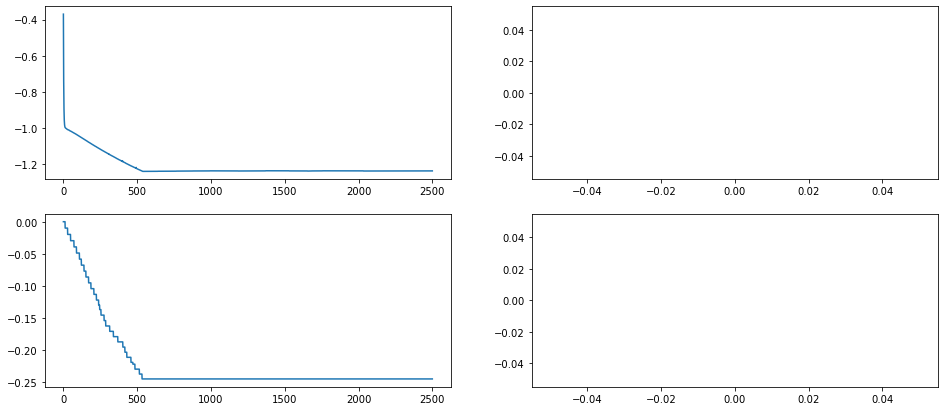

In [17]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,3)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,3)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-5-x-x-x-x'][(3,4)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-5-x-x-x-x'][(3,4)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-2-x-x-x-x-7-x-x'][(5,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-2-x-x-x-x-7-x-x'][(5,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-3-x-x-6-x-x-9'][(7,8)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-x-3-x-x-6-x-x-9'][(7,8)]))
plt.show

### Epsilon - decay check

In [18]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

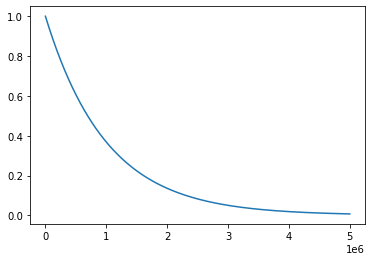

In [19]:
plt.plot(time, epsilon)
plt.show()